In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [66]:
def basis_function(t, grid, k):
    """
    Compute the basis function of order k for the given control points grid over the domain t.

    Parameters:
    - t: Tensor of shape (n,), where n is the number of points in the domain.
    - grid: Tensor of shape (m,), where m is the number of control points.
    - k: Integer, the order of the basis function.

    Returns:
    - value: Tensor of shape (n, m-k-1), the evaluated basis functions over the domain t.
    """
    # Ensure grid is in the correct shape
    grid_ = grid.unsqueeze(dim=0)
    t_ = t.unsqueeze(dim=1)

    # Base case for k=0
    if k == 0:
        value = (t_ >= grid_[:, :-1]) * (t_ < grid_[:, 1:])
        return value
    
    # Recursive case for k > 0
    value_prev = basis_function(t, grid, k-1)
    value1 = (t_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value_prev[:, :-1]
    value2 = (grid_[:, (k+1):] - t_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value_prev[:, 1:]
    value = value1 + value2
    
    return value

In [67]:
def extend_grid(grid, k):
    """
    Ettends the grid on either size by k steps

    Args:
        grid: number of splines t number of control points
        k: spline order

    Returns:
        new_grid: number of splines t (number of control points + 2 * k)
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid

grid = torch.linspace(-1,1,steps = 10)
grid_ = grid.unsqueeze(dim=0)
new_grid = extend_grid(grid_, 2)
new_grid

tensor([[-1.4444, -1.2222, -1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,
          0.3333,  0.5556,  0.7778,  1.0000,  1.2222,  1.4444]])

In [77]:
def eval_basis_functions(t_eval, grid, k):
    """
    Returns the value of basis functions defied for order-k splines and control points defined in `grid`. 

    Args:
        t_eval: number of samples t number of dimensions
        grid: number of splines t number of control points
        k (scalar): order of spline

    Returns:
        bases: number of samples t number of dimensions t number of basis functions
    """
    grid_ = extend_grid(grid, k)
    # Reshape so that each t can be compared to each control point
    grid_ = grid_.unsqueeze(dim=2)
    #print(grid_)
    t_ = t_eval.unsqueeze(dim=1)
    
    for idt in range(k+1):
        if idt == 0:
            bases = (t_ >= grid_[:, :-1]) * (t_ < grid_[:, 1:]) * 1.0 # step function; for each t in between the corresponding knots, the value is 1.
        else:
            bases1 = (t_ - grid_[:, :-(idt+1)]) / (grid_[:, 1:-idt] - grid_[:, :-(idt+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idt+1):] - t_) / (grid_[:, (idt+1):] - grid_[:, 1:-idt]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1,2)

In [78]:
grid = torch.linspace(-1, 1, steps=10)
t = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{t.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
t_ = t.unsqueeze(dim=1)


value1 = eval_basis_functions(t_, grid_, k=0)

value2 = eval_basis_functions(t_, grid_, k=1)

value3 = eval_basis_functions(t_, grid_, k=2)

value4 = eval_basis_functions(t_, grid_, k=3)

print(f"k=0, number of basis functions: {value1.squeeze(1)}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])
k=0, number of basis functions: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12



## Learning the Activation Function, i.e., Coefficients

Now, let's explore whether we can learn the coefficients to emulate certain well-defined functions, with or without noise.

Formally, we define $ f(x) = \sum_{i=0}^{n} c_i \cdot N_{i, k}(x) = \sum_{i=0}^{n} c_i \cdot N_i(x) $.

Given $ x $, we will compute $ N_i(x) $ deterministically. Since we already have a predefined $ f(x) $, this presents a straightforward linear equation model to solve these equations: $ \min_{\mathbf{c}} |\mathbf{Nc} - f(x)| $. We will use `torch.linalg.lstsq` to solve for $ \mathbf{c} $.

Next, let's explore how to use a zero-order spline for predictions.

In [70]:
def fn(x):
    return torch.sin(torch.pi*x)

coefficients = torch.linalg.lstsq(value1.squeeze(1), fn(t))

In [71]:
coefficients

torch.return_types.linalg_lstsq(
solution=tensor([-0.3322, -0.8470, -0.9655, -0.6322, -0.0031,  0.6275,  0.9644,  0.8501,
         0.3380]),
residuals=tensor([]),
rank=tensor(9),
singular_values=tensor([]))

tensor([-0.3322, -0.8470, -0.9655, -0.6322, -0.0031,  0.6275,  0.9644,  0.8501,
         0.3380])
torch.Size([1000])


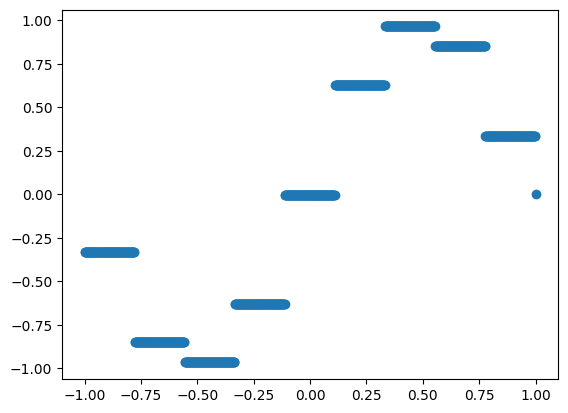

In [72]:
coefficients = torch.linalg.lstsq(value1.squeeze(1), fn(t)).solution
print(coefficients)
y_pred = torch.einsum('i,ji->j',coefficients, value1.squeeze(1))
print(y_pred.shape)
plt.scatter(t, y_pred)

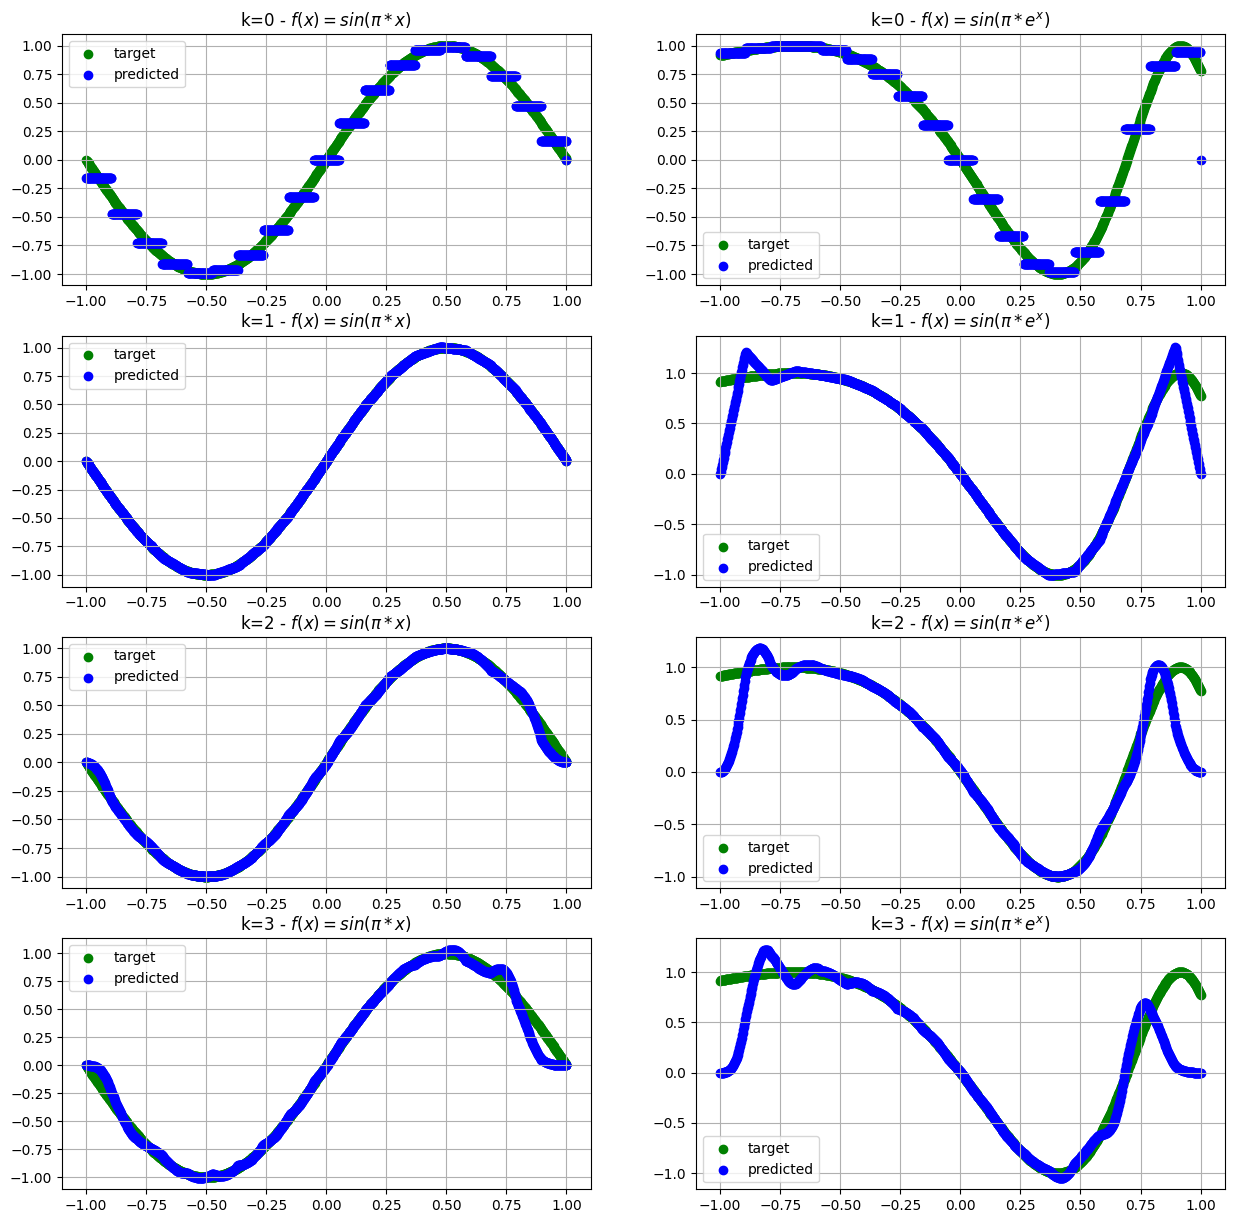

In [74]:
# notice the increase in the grid points to 100
grid = torch.linspace(-1, 1, steps=20) 
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x



value1 = basis_function(x, grid ,k=0)
value2 = basis_function(x, grid ,k=1)
value3 = basis_function(x, grid ,k=2)
value4 = basis_function(x, grid ,k=3)

fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [(value1 * 1.0, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value, fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

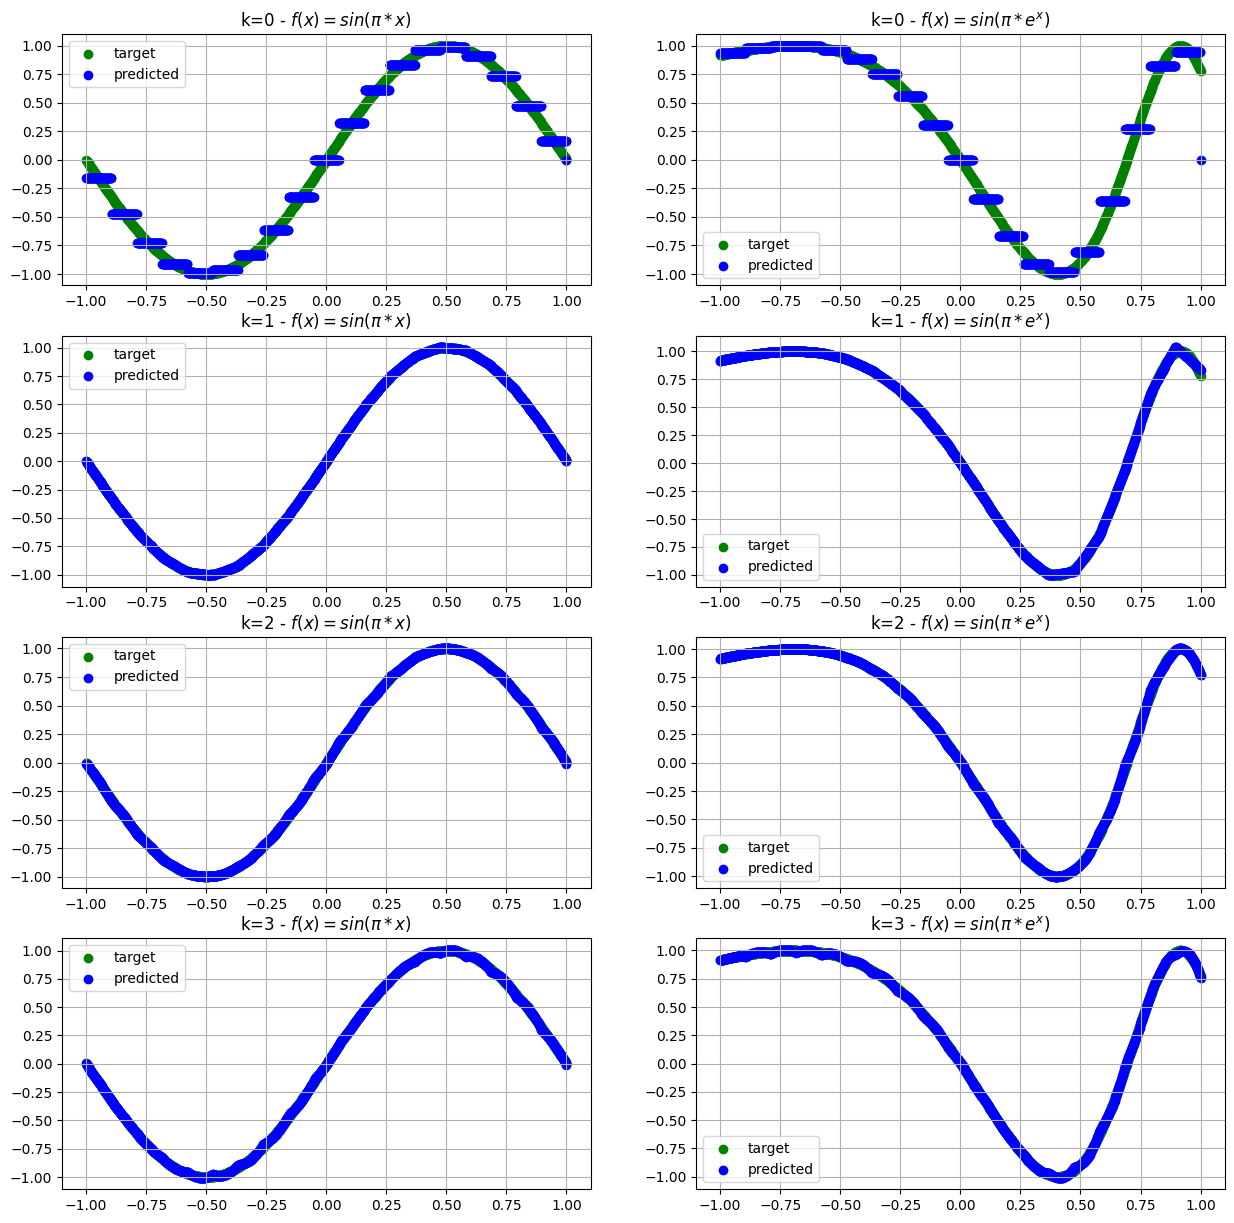

In [84]:
# notice the increase in the grid points to 100
grid = torch.linspace(-1, 1, steps=20) 
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

fns = []
fns += [(lambda x: torch.sin(torch.pi * x) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]

        y_target = fn(x)
        coeff = torch.linalg.lstsq(value.squeeze(1), y_target).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()